In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR, ExponentialLR
from torchvision import datasets, transforms
import yaml
import shutil
import matplotlib.pyplot as plt
import os
import torchvision
import numpy as np
from torch.autograd import Variable
%matplotlib inline

In [3]:
# load the configuration
with open('config/config_cnn.yaml', 'r') as f:
    config = yaml.safe_load(f)

# get the configuration parameters
conv_layers = config['model']['conv_layers']
filter_size = config['model']['filter_size']
stride = config['model']['stride']
padding = config['model']['padding']
pool_type = config['model']['pool_type']
pool_size = config['model']['pool_size']
pool_stride = config['model']['pool_stride']
hidden_layers = config['model']['hidden_layers']
activation_function = config['model']['activation_function']
use_batch_norm = config['model']['use_batch_norm']
dropout_rate = config['model']['dropout_rate']
regularization = config['model']['regularization']
l1_lambda = config['model']['l1_lambda']
l2_lambda = config['model']['l2_lambda']
optimizer_type = config['optimizer']['type']
learning_rate = config['optimizer']['learning_rate']
lr_scheduler = config['optimizer']['lr_scheduler']
step_size = config['optimizer']['step_size']
gamma = config['optimizer']['gamma']
input_size = config['model']['input_size']
output_size = config['model']['output_size']
batch_size = config['batch_size']


# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 128

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.EMNIST(root='./data',split='balanced', train=True,
                                   download=True, transform=transform)
test_data = datasets.EMNIST(root='./data',split='balanced', train=False,
                                  download=True, transform=transform)
print("the number of train data samples: ", len(train_data))
print("the number of test data samples: ", len(test_data))

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

the number of train data samples:  112800
the number of test data samples:  18800


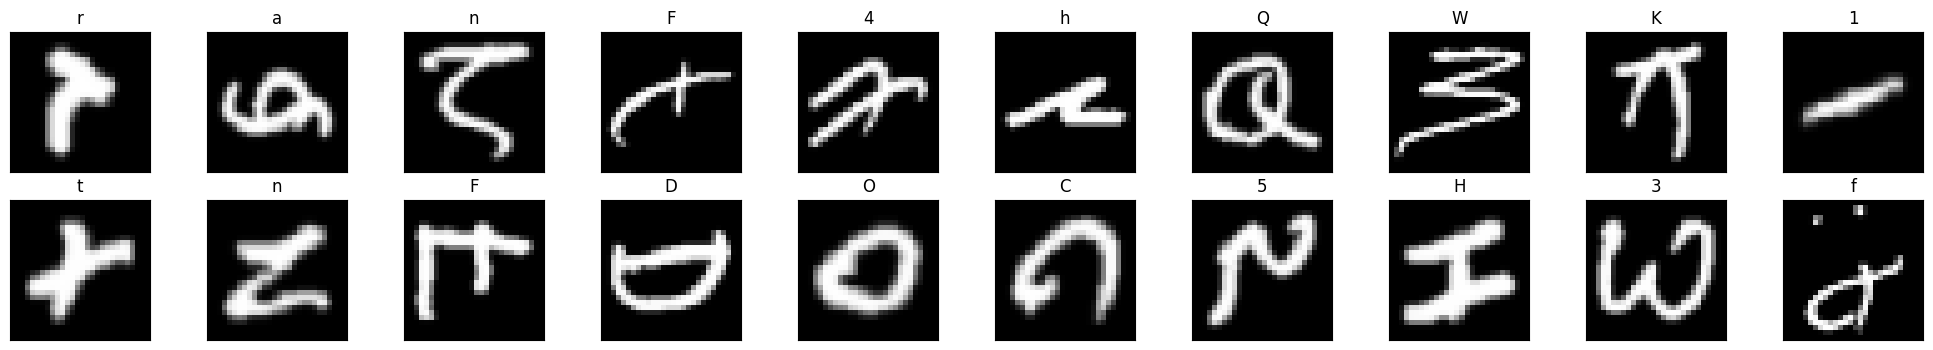

In [4]:
# obtain one batch of training images
dataiter = iter(train_loader)

images, labels = dataiter.__next__()
images = images.numpy()

 # emnist-balanced-mapping.txt 
with open('data/EMNIST/processed/emnist-balanced-mapping.txt') as f: 
    lines = f.readlines()
    
label_dict = {}
for row in lines:
    list1 = row.split(' ')
    label_dict[int(list1[0])] = chr(int(list1[1]))   #索引值 (list1[0])  对应 ASCII code (list1[1])

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(label_dict.get(labels[idx].item())))

In [5]:
img = np.squeeze(images[0])
width, height = img.shape
print(width, height)


28 28


In [12]:
# define the activation function
if activation_function == 'ReLU':
    activation = nn.ReLU()
elif activation_function == 'LeakyReLU':
    activation = nn.LeakyReLU()
elif activation_function == 'ELU':
    activation = nn.ELU()


# define the model
# layers = []
# for i in range(len(conv_layers)):
#     if i == 0:
#         layers.append(nn.Conv2d(input_size[0], conv_layers[i], filter_size[i], stride[i], padding[i]))
#     else:
#         layers.append(nn.Conv2d(conv_layers[i-1], conv_layers[i], filter_size[i], stride[i], padding[i]))
#     layers.append(activation)
#     if pool_type == 'MaxPool':
#         layers.append(nn.MaxPool2d(pool_size[i], pool_stride[i]))
#     elif pool_type == 'AvgPool':
#         layers.append(nn.AvgPool2d(pool_size[i], pool_stride[i]))
#     layers.append(nn.BatchNorm2d(conv_layers[i])) if use_batch_norm else nn.Identity(),
#     layers.append(nn.Dropout(dropout_rate)) if dropout_rate else nn.Identity(),

# for i in range(len(hidden_layers)):
#     if i == 0:
#         layers.append(nn.Linear(conv_layers[-1]*input_size[1]//2**len(conv_layers)*input_size[2]//2**len(conv_layers), hidden_layers[i]))
#     else:
#         layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
#     layers.append(activation)
#     layers.append(nn.BatchNorm1d(hidden_layers[i])) if use_batch_norm else nn.Identity(),
#     layers.append(nn.Dropout(dropout_rate)) if dropout_rate else nn.Identity(),

# layers.append(nn.Linear(hidden_layers[-1], output_size))
# model = nn.Sequential(*layers)
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 64, 3)
        self.dense = nn.Linear(64, 47)
        self.act = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool2d((1,1))
    
    def forward(self, x):
        # Layer 1
        out = self.conv1(x)
        out = self.act(out)

        # Layer 2
        out = self.conv2(out)
        out = self.act(out)
        # Pooling
        out = self.pool(out).flatten(start_dim=-3)
        # Klassifikation
        out = self.dense(out)
        return out
model=CNN()
print(model)

# define the optimizer
if optimizer_type == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
elif optimizer_type == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif optimizer_type == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
elif optimizer_type == 'ASGD':
    optimizer = optim.ASGD(model.parameters(), lr=learning_rate)
elif optimizer_type == 'AdaGrad':
    optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)


# define the learning rate scheduler
if lr_scheduler == 'StepLR':
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
elif lr_scheduler == 'ExponentialLR':
    scheduler = ExponentialLR(optimizer, gamma=gamma)

# define the loss function
if regularization == 'L1':
    criterion = nn.CrossEntropyLoss() # or whatever loss function you are using
    def loss_function(output, target):
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        return criterion(output, target) + l1_lambda * l1_norm
elif regularization == 'L2':
    criterion = nn.CrossEntropyLoss()  # or whatever loss function you are using
    def loss_function(output, target):
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        return criterion(output, target) + l2_lambda * l2_norm
else:
    loss_function = nn.CrossEntropyLoss()  # or whatever loss function you are using

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
  (dense): Linear(in_features=64, out_features=47, bias=True)
  (act): ReLU()
  (pool): AdaptiveAvgPool2d(output_size=(1, 1))
)


In [13]:
# number of epochs to train the model

n_epochs = config['n_epochs']  # suggest training between 20-50 epochs

log_dir = f"hidden_layers_{'_'.join(map(str, hidden_layers))}_activation_{activation_function}"

# create the SummaryWriter
writer = SummaryWriter(f'runs/MLP/{log_dir}')
shutil.copy('config/config_cnn.yaml', f'runs/MLP/{log_dir}/config.yaml')

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

# move model to GPU if CUDA is available
if train_on_gpu:
    model = model.cuda()

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = loss_function(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running trainngi loss
        train_loss += loss.item()*data.size(0)
    scheduler.step()    
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    writer.add_scalar('Training Loss', train_loss, epoch)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

CUDA is available!  Training on GPU ...
torch.Size([128, 64, 24, 24])
torch.Size([128, 64])
torch.Size([128, 64, 24, 24])
torch.Size([128, 64])
torch.Size([128, 64, 24, 24])
torch.Size([128, 64])
torch.Size([128, 64, 24, 24])
torch.Size([128, 64])
torch.Size([128, 64, 24, 24])
torch.Size([128, 64])
torch.Size([128, 64, 24, 24])
torch.Size([128, 64])
torch.Size([128, 64, 24, 24])
torch.Size([128, 64])
torch.Size([128, 64, 24, 24])
torch.Size([128, 64])
torch.Size([128, 64, 24, 24])
torch.Size([128, 64])
torch.Size([128, 64, 24, 24])
torch.Size([128, 64])
torch.Size([128, 64, 24, 24])
torch.Size([128, 64])
torch.Size([128, 64, 24, 24])
torch.Size([128, 64])
torch.Size([128, 64, 24, 24])
torch.Size([128, 64])
torch.Size([128, 64, 24, 24])
torch.Size([128, 64])
torch.Size([128, 64, 24, 24])
torch.Size([128, 64])
torch.Size([128, 64, 24, 24])
torch.Size([128, 64])
torch.Size([128, 64, 24, 24])
torch.Size([128, 64])
torch.Size([128, 64, 24, 24])
torch.Size([128, 64])
torch.Size([128, 64, 24,

KeyboardInterrupt: 

In [ ]:
test_loss = 0.0
class_correct = list(0. for i in range(47))
class_total = list(0. for i in range(47))

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

# move model to GPU if CUDA is available
if train_on_gpu:
    model = model.cuda()

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    # calculate test accuracy for each object class
    for i in range(len(target.data)):  # change here
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

# add the test loss to tensorboard
writer.add_scalar('Test Loss', test_loss)

for i in range(47):
    if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), accuracy,
            np.sum(class_correct[i]), np.sum(class_total[i])))
        # add the accuracy to tensorboard
        writer.add_scalar(f'Test Accuracy/{i}', accuracy)
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

overall_accuracy = 100. * np.sum(class_correct) / np.sum(class_total)
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    overall_accuracy,
    np.sum(class_correct), np.sum(class_total)))

# add the overall accuracy to tensorboard
writer.add_scalar('Test Accuracy/Overall', overall_accuracy)

# close the SummaryWriter
writer.close()

Test Loss: 0.671302

Test Accuracy of     0: 51% (207/400)
Test Accuracy of     1: 74% (299/400)
Test Accuracy of     2: 79% (319/400)
Test Accuracy of     3: 82% (330/400)
Test Accuracy of     4: 78% (315/400)
Test Accuracy of     5: 71% (284/400)
Test Accuracy of     6: 78% (312/400)
Test Accuracy of     7: 94% (377/400)
Test Accuracy of     8: 82% (331/400)
Test Accuracy of     9: 68% (275/400)
Test Accuracy of    10: 90% (363/400)
Test Accuracy of    11: 86% (345/400)
Test Accuracy of    12: 85% (341/400)
Test Accuracy of    13: 78% (315/400)
Test Accuracy of    14: 91% (367/400)
Test Accuracy of    15: 55% (221/400)
Test Accuracy of    16: 88% (352/400)
Test Accuracy of    17: 86% (345/400)
Test Accuracy of    18: 57% (228/400)
Test Accuracy of    19: 87% (351/400)
Test Accuracy of    20: 87% (348/400)
Test Accuracy of    21: 37% (150/400)
Test Accuracy of    22: 81% (325/400)
Test Accuracy of    23: 87% (350/400)
Test Accuracy of    24: 48% (195/400)
Test Accuracy of    25: 95% (

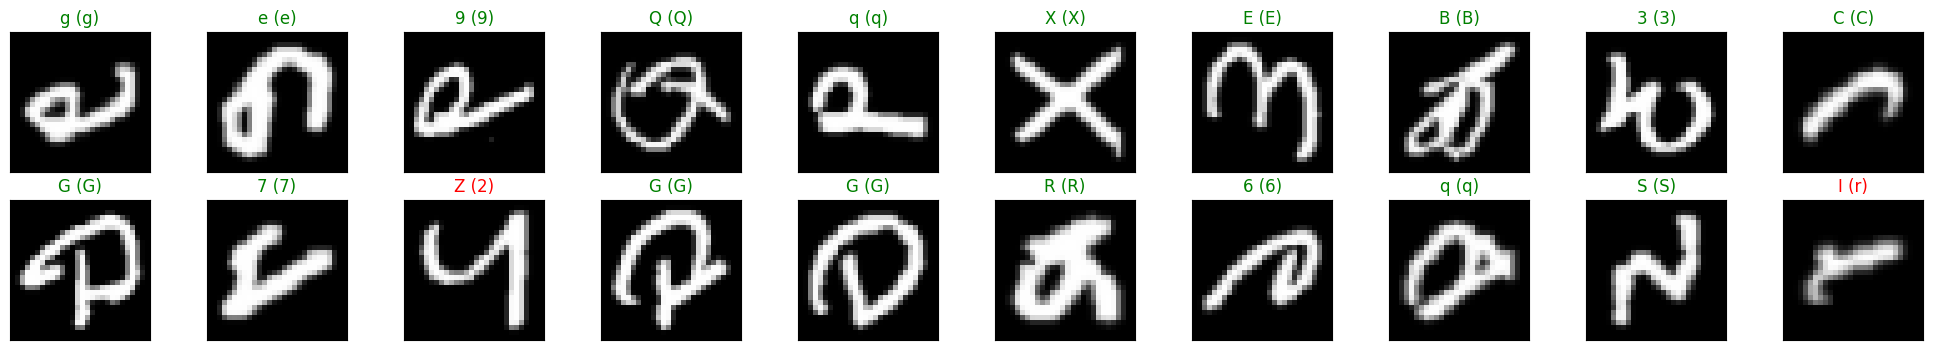

In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

# move model to GPU if CUDA is available
if train_on_gpu:
    model = model.cuda()

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.__next__()

# move images and labels to GPU if CUDA is available
if train_on_gpu:
    images, labels = images.cuda(), labels.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

# move images and preds back to CPU for displaying images and numpy operations
if train_on_gpu:
    images, preds = images.cpu(), preds.cpu()

# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(label_dict.get(preds[idx].item())), str(label_dict.get(labels[idx].item()))),
                 color=("green" if preds[idx]==labels[idx] else "red"))